In [1]:
import os

import gymnasium as gym
import mediapy as media
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm

from legato.nets import *

In [2]:
# Set mujoco to use EGL
os.environ["MUJOCO_GL"] = "egl"

In [3]:
# Load models
state_encoder = torch.load('trained_net_params/state_encoder.pt')
action_encoder = torch.load('trained_net_params/action_encoder.pt')
transiton_model = torch.load('trained_net_params/transition_model.pt')
state_decoder = torch.load('trained_net_params/state_decoder.pt')
action_decoder = torch.load('trained_net_params/action_decoder.pt')

In [4]:
action_space_size = 1.0

In [5]:
# Now let's optimize a trajectory

actor = ActorPolicy(
    2,
    action_space_size,
    state_encoder,
    transiton_model,
    action_decoder,
    decay=1.0,
    horizon=128,
    iters=128,
).cuda()

# actor = torch.compile(actor)

env = gym.make("PointMaze_Medium-v3", render_mode="rgb_array")
obs, info = env.reset()
state = torch.tensor(obs["observation"], dtype=torch.float32, device="cuda")
latent_action_plan = None

initial_state = state
target_state = torch.tensor(
    [*obs["desired_goal"], 0, 0], dtype=torch.float32, device="cuda"
)

actions = []
states = [initial_state]

frames = [env.render()]

loss_curves = []
for i in tqdm(range(256), disable=True):
    next_action, latent_action_plan, loss_curve = actor(
        state[None], target_state[None], latent_action_plan, return_curve=True
    )
    # latent_action_plan[:] = 1
    loss_curves.append(loss_curve)
    obs, rew, term, trunc, info = env.step(next_action[0].cpu().numpy())
    state = torch.tensor(obs["observation"], dtype=torch.float32, device="cuda")

    actions.append(next_action[0].cpu().numpy())
    states.append(state)

    frames.append(env.render())
    print(f"Iteration {i}, action: {next_action[0].cpu().numpy()}")

traj_actions = torch.tensor(actions, dtype=torch.float32, device="cuda")
traj_states = torch.stack(states, dim=0)

/home/mishmish/Documents/venvs/legato_simple/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([1, 128, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.014065451920032501
Iteration 0, action: [ -3.503977 -32.98957 ]
72.68914794921875
Iteration 1, action: [-72.730354  43.152527]
42.17142105102539
Iteration 2, action: [  -5.9010797 -123.71111  ]
84.43716430664062
Iteration 3, action: [ -71.806435 -167.40009 ]
63.6786003112793
Iteration 4, action: [-125.963936   36.82749 ]
39.07283020019531
Iteration 5, action: [-231.0586    -28.454754]
101.144775390625
Iteration 6, action: [-248.23746  -67.9559 ]
91.50023651123047
Iteration 7, action: [  61.418583 -144.88191 ]
192.56015014648438
Iteration 8, action: [-31.34592   25.629417]
529.921630859375
Iteration 9, action: [ 34.485153 127.28501 ]
630.5948486328125
Iteration 10, action: [-55.265663    6.0676622]
1453.227783203125
Iteration 11, action: [-69.33829 171.1714 ]
1339.96240234375
Iteration 12, action: [-354.90735    43.005833]
1073.9111328125
Iteration 13, action: [-319.589     -31.753017]
685.879638671875
Iteration 14, action: [-362.16602      2.9693356]
444.65386962890625
Iteration 15, 

/tmp/ipykernel_2756619/1934207998.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  traj_actions = torch.tensor(actions, dtype=torch.float32, device="cuda")


<Axes: >

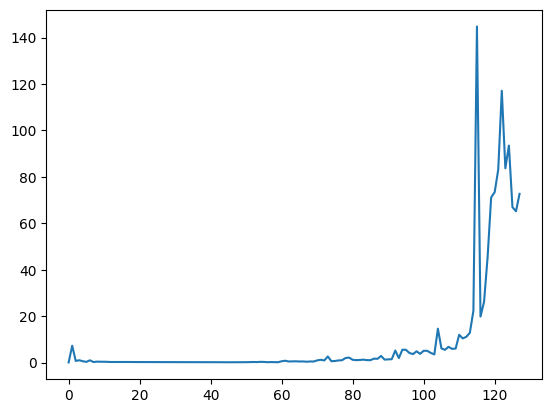

In [6]:
curve = loss_curves[1]
# Plot the loss curve with i as the x axis
sns.lineplot(x=range(len(curve)), y=curve)

In [7]:
# Show the video
media.show_video(frames, fps=30)

In [8]:
# Load data from data.npz
data = np.load("data.npz")
torchify = lambda *xs: [torch.tensor(x, dtype=torch.float32, device="cuda") for x in xs]
# torchify = lambda *xs: [torch.tensor(x, dtype=torch.float32) for x in xs]
observations, actions = torchify(data["observations"], data["actions"])
# observations, actions = observations[:4096], actions[:4096]

In [9]:
latent_traj_states = state_encoder(traj_states)
latent_traj_actions = action_encoder(traj_actions, traj_states[..., :-1, :])
latent_initial_state = state_encoder(initial_state[None])

predicted_fut_latent_states, mask = transiton_model(
    latent_initial_state, latent_traj_actions[None], return_mask=True
)
predicted_fut_states = state_decoder(predicted_fut_latent_states)
actual_fut_states = traj_states[1:]
latent_traj_states = state_encoder(traj_states)
actual_fut_latent_states = state_encoder(actual_fut_states)

In [10]:
actual_fut_latent_states = state_encoder(actual_fut_states)

In [11]:
traj_actions

tensor([[-3.5040e+00, -3.2990e+01],
        [-7.2730e+01,  4.3153e+01],
        [-5.9011e+00, -1.2371e+02],
        [-7.1806e+01, -1.6740e+02],
        [-1.2596e+02,  3.6827e+01],
        [-2.3106e+02, -2.8455e+01],
        [-2.4824e+02, -6.7956e+01],
        [ 6.1419e+01, -1.4488e+02],
        [-3.1346e+01,  2.5629e+01],
        [ 3.4485e+01,  1.2729e+02],
        [-5.5266e+01,  6.0677e+00],
        [-6.9338e+01,  1.7117e+02],
        [-3.5491e+02,  4.3006e+01],
        [-3.1959e+02, -3.1753e+01],
        [-3.6217e+02,  2.9693e+00],
        [ 5.1046e+01,  1.0900e+02],
        [-9.3482e+01,  2.5288e+02],
        [-5.8267e+01,  7.8114e+01],
        [-2.8212e+02, -2.1879e+01],
        [-1.4037e+02,  1.6482e+02],
        [-3.7358e+02,  2.1433e+01],
        [-1.2543e+02,  4.1382e+00],
        [ 4.0652e+01,  1.6011e+02],
        [-3.0073e+01,  1.0944e+02],
        [-1.1705e+03, -3.0977e+02],
        [ 4.4322e+01, -1.1526e+02],
        [-7.0470e+02, -5.5999e+02],
        [-1.3971e+02, -1.094

In [12]:
traj_states

tensor([[-1.2679e+00, -3.5795e-01,  0.0000e+00,  0.0000e+00],
        [-1.2703e+00, -3.6033e-01, -2.3816e-01, -2.3816e-01],
        [-1.2750e+00, -3.6033e-01, -4.7576e-01,  5.6722e-04],
        ...,
        [-2.8950e+00, -1.0694e+00,  2.9533e-01, -3.4293e+00],
        [-2.8944e+00, -1.1060e+00,  5.6460e-02, -3.6593e+00],
        [-2.8962e+00, -1.1402e+00, -1.8184e-01, -3.4124e+00]], device='cuda:0')

In [13]:
reconstructed_traj_actions = action_decoder(latent_traj_actions, latent_traj_states[..., :-1, :])

In [14]:
reconstructed_traj_actions

tensor([[-1.3217e+01, -2.6338e+01],
        [-6.2641e+01, -2.5997e+00],
        [-4.5133e+01, -9.5189e+01],
        [-9.8023e+01, -1.3578e+02],
        [-1.0335e+02, -2.4262e+01],
        [-1.9423e+02, -1.1443e+02],
        [-2.1072e+02, -1.2892e+02],
        [-2.3867e+01, -1.1513e+02],
        [-3.1046e+01,  1.5301e+00],
        [-5.9826e+01,  9.8775e+00],
        [-4.6736e+01, -1.8086e+01],
        [-1.3636e+02,  6.6189e+00],
        [-2.8627e+02, -1.2491e+02],
        [-2.6522e+02, -1.5690e+02],
        [-2.9193e+02, -1.5839e+02],
        [-3.7530e+01,  1.0913e+01],
        [-1.9706e+02,  9.0719e+00],
        [-7.1707e+01,  3.6235e+00],
        [-2.3221e+02, -1.3696e+02],
        [-1.5571e+02,  4.1509e+00],
        [-3.0315e+02, -1.4514e+02],
        [-1.0276e+02, -5.0297e+01],
        [-7.7022e+01,  1.1899e+01],
        [-8.1305e+01,  5.6212e+00],
        [-9.8435e+02, -6.1092e+02],
        [-2.1393e+01, -9.1656e+01],
        [-6.8346e+02, -5.8763e+02],
        [-1.3607e+02, -1.152

In [15]:
predicted_fut_latent_states

tensor([[[ 25.0453,  38.5478,  -3.7535, -61.3689],
         [ 25.8855,  38.2658,  -2.6948, -61.0201],
         [ 27.0785,  38.3208,  -5.0360, -61.9047],
         ...,
         [ 22.4072,  32.4887,  -1.6543, -53.9705],
         [ 30.0650,  42.6397,  -4.2809, -66.7909],
         [ 30.2199,  39.1928,  -2.5666, -64.2056]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [16]:
actual_fut_latent_states

tensor([[ 0.7085, -0.2633,  0.1798, -0.7337],
        [ 0.7137, -0.2719,  0.1936, -0.7402],
        [ 0.7181, -0.2960,  0.1787, -0.7479],
        ...,
        [ 0.7524, -0.1120, -0.0741, -0.8473],
        [ 0.7507, -0.1425, -0.0913, -0.8429],
        [ 0.7516, -0.1555, -0.0702, -0.8491]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [17]:
predicted_fut_states

tensor([[[-271.0628,  132.4190, -211.3981,  122.5220],
         [-269.0097,  126.0729, -217.6808,  127.9632],
         [-280.3891,  116.0068, -221.8704,  113.6634],
         ...,
         [-232.2657,  115.0832, -201.4123,  116.5905],
         [-304.1022,  122.6497, -236.6071,  132.0102],
         [-288.3505,  108.1241, -249.7601,  134.4428]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [18]:
actual_fut_states

tensor([[-1.2703e+00, -3.6033e-01, -2.3816e-01, -2.3816e-01],
        [-1.2750e+00, -3.6033e-01, -4.7576e-01,  5.6722e-04],
        [-1.2822e+00, -3.6270e-01, -7.1279e-01, -2.3760e-01],
        ...,
        [-2.8950e+00, -1.0694e+00,  2.9533e-01, -3.4293e+00],
        [-2.8944e+00, -1.1060e+00,  5.6460e-02, -3.6593e+00],
        [-2.8962e+00, -1.1402e+00, -1.8184e-01, -3.4124e+00]], device='cuda:0')

In [19]:
predicted_fut_latent_states

tensor([[[ 25.0453,  38.5478,  -3.7535, -61.3689],
         [ 25.8855,  38.2658,  -2.6948, -61.0201],
         [ 27.0785,  38.3208,  -5.0360, -61.9047],
         ...,
         [ 22.4072,  32.4887,  -1.6543, -53.9705],
         [ 30.0650,  42.6397,  -4.2809, -66.7909],
         [ 30.2199,  39.1928,  -2.5666, -64.2056]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [20]:
actual_fut_latent_states

tensor([[ 0.7085, -0.2633,  0.1798, -0.7337],
        [ 0.7137, -0.2719,  0.1936, -0.7402],
        [ 0.7181, -0.2960,  0.1787, -0.7479],
        ...,
        [ 0.7524, -0.1120, -0.0741, -0.8473],
        [ 0.7507, -0.1425, -0.0913, -0.8429],
        [ 0.7516, -0.1555, -0.0702, -0.8491]], device='cuda:0',
       grad_fn=<AddmmBackward0>)